<a href="https://colab.research.google.com/github/konpatel/pneumonia-detection/blob/master/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_labels=pd.read_csv("/content/drive/MyDrive/pneumonia-detection/labels_train.csv",dtype=str)
training_dir = '/content/drive/MyDrive/pneumonia-detection/train_images'
validation_dir = '/content/drive/MyDrive/pneumonia-detection/validation_images'
test_dir = '/content/drive/MyDrive/pneumonia-detection/test_images'

In [ ]:
from PIL import Image  
import PIL  
picture = Image.open('/content/drive/MyDrive/pneumonia-detection/validation_images')  
picture = picture.save("dolls.jpg") 

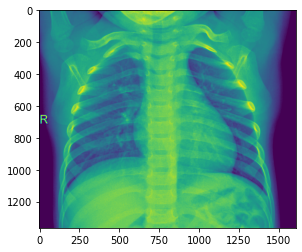

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(training_dir + '/img_29479052568887578.jpg')
imgplot = plt.imshow(img)
plt.show()

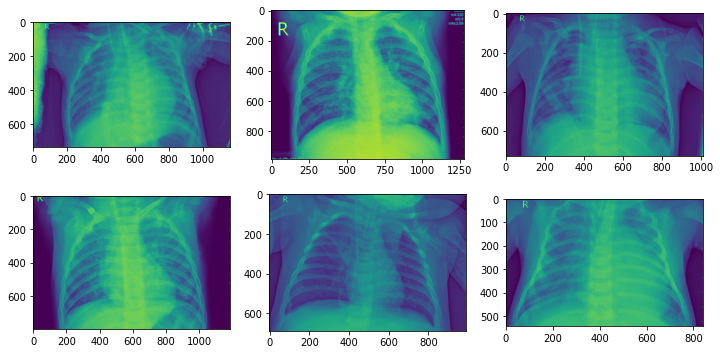

In [4]:
import os

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1


plot_images(training_dir + '/')

In [ ]:
#Διάσταση κάθε εικόνας
IMAGE_SIZE    = (224, 224)
#Αριθμός κατηγοριών που θα γίνει το classification
NUM_CLASSES   = 3
#Σύνολο εικόνων που θα τροφοδοτούμε το μοντέλο κάθε φορά
BATCH_SIZE    = 32  
#Αριθμός Εποχών
NUM_EPOCHS    = 10
#Βήματα εποχών
STEPS_PER_EPOCH=100
#RESCALE
rescale = 1./255.0
#Filename του μοντέλου
WEIGHTS_FINAL = 'model-final.h5'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory="/content/drive/MyDrive/pneumonia-detection/train_images/",
    x_col="file_name",
    y_col="class_id",
    subset="training",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)

In [ ]:
validation_datagen=ImageDataGenerator(rescale=1./255.)
validation_generator=validation_datagen.flow_from_directory(    
    dataframe=train_labels,
    directory="/content/drive/MyDrive/pneumonia-detection/validation_images/",    
    seed=42,
    shuffle=False,
    class_mode=None,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE)

Found 0 images belonging to 0 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(    
    directory="/content/drive/MyDrive/MachineLearningImages/test_images/data",    
    seed=42,
    shuffle=False,
    class_mode=None,
    batch_size=1,
    target_size=IMAGE_SIZE)

Found 0 images belonging to 0 classes.


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

conv_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = Flatten()(conv_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
full_model.summary()



In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2)
# early_stop = EarlyStopping(monitor='val_loss', patience=10)

full_model.fit(train_generator,
                        validation_data = validation_generator,
                        batch_size=BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        callbacks=[checkpoint],
                        verbose=1)

# save trained weights
full_model.save(WEIGHTS_FINAL)

result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])